In [1]:
import utils
import time
import os
import matplotlib.pyplot as plt
import librosa, librosa.display
import numpy as np

In [2]:
tracks = utils.load_csv("tracks")
train_tracks = tracks[tracks["set", "split"] == "training"]
validate_tracks = tracks[tracks["set", "split"] == "validation"]
test_tracks = tracks[tracks["set", "split"] == "test"]
del tracks

In [3]:
sr = 22050

### Random Sample

In [9]:
random_sample = train_tracks.sample()
sample_id = random_sample.index[0]
sample_genre = random_sample["track", "genre_top"].item()
sample_waveform, sr = utils.load_waveform(sample_id, sr=sr)
print(f"Track ID: {sample_id}, Genre: {sample_genre}")

Track ID: 122632, Genre: Instrumental


#### CQT

Shape of CQT: (84, 323)


Text(0.5, 1.0, 'CQT')

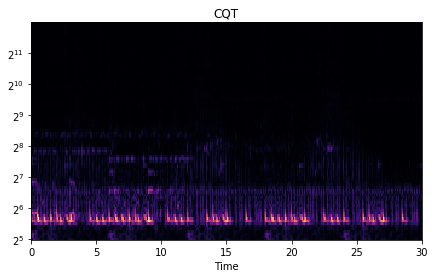

In [10]:
sample_cqt = np.abs(librosa.cqt(sample_waveform, sr=sr, hop_length=2048, bins_per_octave=12, n_bins=7*12))
print(f"Shape of CQT: {sample_cqt.shape}")

plt.figure(figsize=(7, 4))
librosa.display.specshow(sample_cqt, y_axis="cqt", x_axis="time", sr=sr, hop_length=2048)
plt.title("CQT")

#### Chroma CQT and CENS

Shape of Chroma CQT: (12, 323), Chroma CENS: (12, 323)


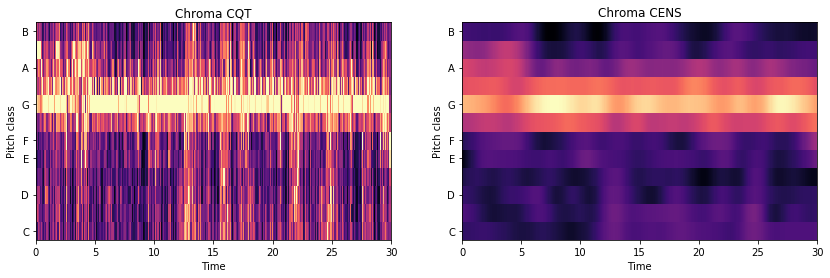

In [11]:
chroma_cqt = librosa.feature.chroma_cqt(C=sample_cqt, hop_length=2048)
chroma_cens = librosa.feature.chroma_cens(C=sample_cqt, hop_length=2048, sr=sr)
print(f"Shape of Chroma CQT: {chroma_cqt.shape}, Chroma CENS: {chroma_cens.shape}")

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(chroma_cqt, sr=sr, hop_length=2048, y_axis="chroma", x_axis="time")
plt.title("Chroma CQT")
plt.subplot(1, 2, 2)
plt.title("Chroma CENS")
librosa.display.specshow(chroma_cens, sr=sr, hop_length=2048, y_axis="chroma", x_axis="time")

#### Linear and Mel scale STFT

Shape of Linear STFT: (257, 323), Mel STFT: (128, 323)


Text(0.5, 1.0, 'Mel STFT')

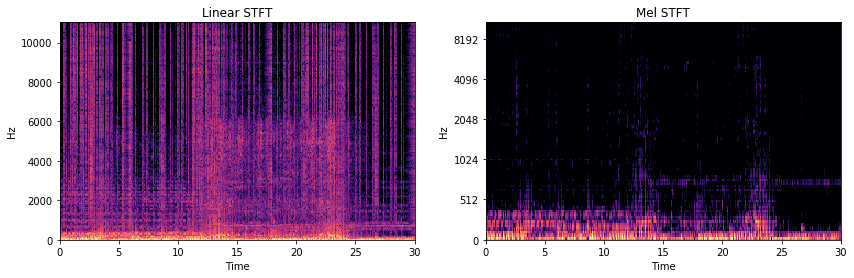

In [12]:
stft_linear = np.abs(librosa.stft(sample_waveform, n_fft=512, hop_length=2048))
stft_linear_db = librosa.amplitude_to_db(stft_linear, ref=np.max)
stft_mel = librosa.feature.melspectrogram(S=stft_linear**2, n_fft=512, hop_length=2048)
stft_mel_db = librosa.amplitude_to_db(stft_mel, ref=np.max)

print(f"Shape of Linear STFT: {stft_linear_db.shape}, Mel STFT: {stft_mel_db.shape}")

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(stft_linear_db, x_axis="time", y_axis="linear", sr=sr, hop_length=2048)
plt.title("Linear STFT")
plt.subplot(1, 2, 2)
librosa.display.specshow(stft_mel_db, x_axis="time", y_axis="mel", sr=sr, hop_length=2048)
plt.title("Mel STFT")

#### Chroma STFT

Shape of Chroma STFT: (12, 323)


Text(0.5, 1.0, 'Chroma STFT')

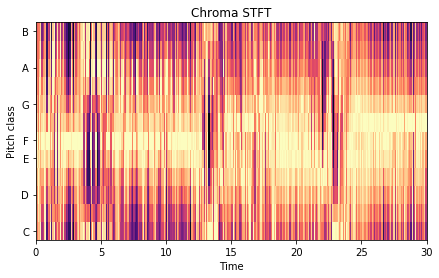

In [13]:
chroma_stft = librosa.feature.chroma_stft(S=stft_linear**2, hop_length=2048, n_fft=512, n_chroma=12)
print(f"Shape of Chroma STFT: {chroma_stft.shape}")

plt.figure(figsize=(7, 4))
librosa.display.specshow(chroma_stft, y_axis="chroma", x_axis="time", sr=sr, hop_length=2048)
plt.title("Chroma STFT")

### Create directory to store features

In [ ]:
if not os.path.isdir("data/features"):
    os.makedirs("data/features")

if not os.path.isdir("data/features/ids"):
    os.makedirs("data/features/ids")

if not os.path.isdir("data/features/cqt"):
    os.makedirs("data/features/cqt")

if not os.path.isdir("data/features/chroma_cqt"):
    os.makedirs("data/features/chroma_cqt")
    
if not os.path.isdir("data/features/chroma_cens"):
    os.makedirs("data/features/chroma_cens")

if not os.path.isdir("data/features/stft"):
    os.makedirs("data/features/stft")

if not os.path.isdir("data/features/linear_stft"):
    os.makedirs("data/features/linear_stft")

if not os.path.isdir("data/features/mel_stft/"):
    os.makedirs("data/features/mel_stft/")

if not os.path.isdir("data/features/chroma_stft"):
    os.makedirs("data/features/chroma_stft")

### Create CQTs for each track

In [ ]:
test_ids, test_cqts, test_failed_ids = utils.create_feature_array(test_tracks, "cqt")
np.save("data/features/cqt/test_cqts.npy", test_cqts)
np.save("data/features/ids/test_ids.npy", test_ids)
np.save("data/features/ids/test_failed_ids.npy", test_failed_ids)

In [ ]:
validate_ids, validate_cqts, validate_failed_ids = utils.create_feature_array(validate_tracks, "cqt")
np.save("data/features/cqt/validate_cqts.npy", validate_cqts)
np.save("data/features/ids/validate_ids.npy", validate_ids)
np.save("data/features/ids/validate_failed_ids.npy", validate_failed_ids)

In [ ]:
n_chunks = 8
chunk_len = int(train_tracks.shape[0] / n_chunks)

for chunk_i in range(n_chunks):
    start_i = chunk_len * chunk_i
    end_i = chunk_len * (chunk_i + 1) if chunk_i != (n_chunks - 1) else train_tracks.shape[0]
    chunk = train_tracks.iloc[start_i:end_i]
    train_ids, train_cqts, train_failed_ids = utils.create_feature_array(chunk, "cqt")
    np.save(f"data/features/cqt/train_cqts_{chunk_i}.npy", train_cqts)
    np.save(f"data/features/ids/train_ids_{chunk_i}.npy", train_ids)
    np.save(f"data/features/ids/train_failed_ids_{chunk_i}.npy", train_failed_ids)

### Create Chroma CQT and CENS for each track

In [ ]:
def create_chroma_from_cqt(cqts_arr, type):
    print(f"Processing chroma_{type}")
    chromas = np.empty((0, 12, 320))
    count = 0
    start = time.time()
    for cqt in cqts_arr:
        count += 1
        if count % 100 == 0:
            print(f"{utils.time_since(start)}, Processing {count} out of {cqts_arr.shape[0]}")

        if type == "cqt":
            chroma = librosa.feature.chroma_cqt(C=cqt)
        elif type == "cens":
            chroma = librosa.feature.chroma_cens(C=cqt)
        chromas = np.append(chromas, [chroma], axis=0)

    return chromas

In [ ]:
test_cqts = np.load("data/features/cqt/test_cqts.npy")
test_chroma_cqts = create_chroma_from_cqt(test_cqts, "cqt")
test_chroma_cens = create_chroma_from_cqt(test_cqts, "cens")
np.save("data/features/chroma_cqt/test_chroma_cqts.npy", test_chroma_cqts)
np.save("data/features/chroma_cens/test_chroma_cens.npy", test_chroma_cens)
    

In [ ]:
validate_cqts = np.load("data/features/cqt/validate_cqts.npy")
validate_chroma_cqts = create_chroma_from_cqt(validate_cqts, "cqt")
validate_chroma_cens = create_chroma_from_cqt(validate_cqts, "cens")
np.save("data/features/chroma_cqt/validate_chroma_cqts.npy", validate_chroma_cqts)
np.save("data/features/chroma_cens/validate_chroma_cens.npy", validate_chroma_cens)
    

In [ ]:
n_chunks = 8

for i in range(n_chunks):
    print(f"Processing chunk {i}")
    train_cqts = np.load(f"data/features/cqt/train_cqts_{i}.npy")
    train_chroma_cqts = create_chroma_from_cqt(train_cqts, "cqt")
    train_chroma_cens = create_chroma_from_cqt(train_cqts, "cens")
    np.save(f"data/features/chroma_cqt/train_chroma_cqts_{i}.npy", train_chroma_cqts)
    np.save(f"data/features/chroma_cens/train_chroma_cens_{i}.npy", train_chroma_cens)

### Create STFT

In [ ]:
test_ids, test_stfts, test_failed_ids = utils.create_feature_array(test_tracks, "stft")
np.save("data/features/stft/test_stfts.npy", test_stfts)

In [ ]:
validate_ids, validate_stfts, validate_failed_ids = utils.create_feature_array(validate_tracks, "stft")
np.save("data/features/stft/validate_stfts.npy", validate_stfts)

In [ ]:
n_chunks = 8
chunk_len = int(train_tracks.shape[0] / n_chunks)

for chunk_i in range(n_chunks):
    start_i = chunk_len * chunk_i
    end_i = chunk_len * (chunk_i + 1) if chunk_i != (n_chunks - 1) else train_tracks.shape[0]
    chunk = train_tracks.iloc[start_i:end_i]
    train_ids, train_stfts, train_failed_ids = utils.create_feature_array(chunk, "stft")
    np.save(f"data/features/stft/train_stfts_{chunk_i}.npy", train_stfts)

### Create Linear and Mel Scale STFT in dB, and Chroma STFT

In [ ]:
def create_from_stft(stfts, type):
    print(f"Processing {type} scale STFT")
    type_size = {"linear": (257, 320), "mel": (128, 320), "chroma": (12, 320)}
    feature_arr = np.empty((0, type_size[type][0], type_size[type][1]))

    count = 0
    start = time.time()
    for stft in stfts:
        count += 1
        if count % 100 == 0:
            print(f"{utils.time_since(start)}, Processing {count} out of {stfts.shape[0]}")
    
        if type == "linear":
            feature = librosa.amplitude_to_db(stft, ref=np.max)
        elif type == "mel":
            feature = librosa.feature.melspectrogram(S=stft**2, n_fft=512, hop_length=2048)
        elif type == "chroma":
            feature = librosa.feature.chroma_stft(S=stft**2, n_fft=512, hop_length=2048, n_chroma=12)
        feature_arr = np.append(feature_arr, [feature], axis=0)
    
    return feature_arr

In [ ]:
test_stfts = np.load("data/features/stft/test_stfts.npy")
np.save("data/features/linear_stft/test_linear_stfts.npy", create_from_stft(test_stfts, "linear"))
np.save("data/features/mel_stft/test_mel_stfts.npy", create_from_stft(test_stfts, "mel"))
np.save("data/features/chroma_stft/test_chroma_stfts.npy", create_from_stft(test_stfts, "chroma"))


In [ ]:
validate_stfts = np.load("data/features/stft/validate_stfts.npy")
np.save("data/features/linear_stft/validate_linear_stfts.npy", create_from_stft(validate_stfts, "linear"))
np.save("data/features/mel_stft/validate_mel_stfts.npy", create_from_stft(validate_stfts, "mel"))
np.save("data/features/chroma_stft/validate_chroma_stfts.npy", create_from_stft(validate_stfts, "chroma"))

In [ ]:
n_chunks = 8

for i in range(n_chunks):
    print(f"Processing chunk {i}")
    train_stfts = np.load(f"data/features/stft/train_stfts_{i}.npy")
    np.save(f"data/features/linear_stft/train_linear_stfts_{i}.npy", create_from_stft(train_stfts, "linear"))
    np.save(f"data/features/mel_stft/train_mel_stfts_{i}.npy", create_from_stft(train_stfts, "mel"))
    np.save(f"data/features/chroma_stft/train_chroma_stfts_{i}.npy", create_from_stft(train_stfts, "chroma"))    